In [1]:
# -*- coding: utf-8 -*-
"""
Revised on Jun.8.2021

6-2-BiClsMLP-NewsCisDept-scrambled-rmsprop

@author: Johnson

"""
import csv
import logging
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM
import numpy as np
from numpy import asarray 
from numpy import zeros
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/abner0908/anaconda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abner0908/anaconda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abner0908/anaconda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/abner0908/anaconda2/lib/python3.7/site-packages/tensorflow/python/f

In [ ]:
# log:

# 2021.6.9 16:xx  (max_length = 1000,output_dim=512, epochs=20, 1-3rd Dense(), Dropout(0.1), batch_size=512)  => Ok
# vocab_size = 70000
# max_length = 1000
# model.add(Embedding(output_dim=512, input_dim=vocab_size, input_length=max_length)) 
# history = model.fit(x_train, trainLabel, batch_size=512, epochs=20, verbose=2, validation_data=(x_test,testLabel))
# Accuracy: 83.807695

# 2021.6.19: (max_length = 1000,output_dim=512, epochs=20, 1-3rd Dense(), Dropout(0.1), batch_size=50)
# vocab_size = 70000
# max_length = 1000
# valid length = 2000, train length= 8000
# model.add(Embedding(output_dim=512, input_dim=vocab_size, input_length=max_length)) 
# history = model.fit(partial_x_train, partial_trainLabel, batch_size=50, epochs=20, verbose=2, validation_data=(x_val,y_val))
# Accuracy: 80-83

## Step 1: Read KCC News, Cis, and Dept data
### 原始資料來源: NewsCisDepAll-35325.csv
#### (1) 首段為2009.1至2019.8高雄市議會新聞約 11,554筆
#### (2) 中段為1屆1次至2屆8次議事錄市政總質詢約 7,296筆 (經人工依主題分段)
#### (3) 末段為1屆1次至3屆1次部門質詢約16,600筆（已分段）
### 標記資料說明:
#### (1) L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym.txt
####      總數約10,140 筆, 按原始資料順序於Category欄標記類別, Sentiment欄標記情緒, 並以CkipTagger(辭典KccDict2020, 無同義字)斷詞
#### (2) L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym-pos-neg-balance.txt
#### =>  同(1), 惟依 Sentiment 欄排序, 前段 2,451 Sentiment 欄為0, 後段2,451 筆均為 1
#### (3) L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym - Sort by sent.txt  
#### =>  同(1), 惟依 Sentiment 欄排序, 前段 7,689 Sentiment 欄為0, 後段2,451 筆均為 1
#### (4) L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym - Sort by cat.txt  
#### =>  同 (1), 惟依 Category 欄由 0至72 排序
### dump labeled data into train and test list from labeled file
### 資料長度: 斷詞後News最長約500字, CIS分割後每筆最長約1000字, Dept 分割後每筆最長約800字

In [287]:
csvIn = open("L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym.txt", 'r', newline='', encoding='utf-8-sig')
#KCC Data/WS Out/L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym-pos-neg-balance.txt"
#這ㄍ有沒有混到其它資料、出現在哪
rowlists =csv.reader(csvIn)        # read train data from labeled file
tmpLab = []
tmpTx = []
tmpFilename=[]
tmpCunt = 0
for row in rowlists:
    # 濾除未標記和過短資料
    if (row[3] == "1" or row[3] == "0") and (len(row[4]) > 50) and (("/" in row[1])==False):
        tmpLab.append(int(row[3]))
        tmpTx.append(row[4])
        tmpFilename.append(row[1])
        tmpCunt += 1
csvIn.close()
print("總輸入檔案筆數: ",len(row))
print("row[0] = ",row[0]) #第4-5 筆資料
print("----------------------------------")
data = np.array(tmpTx)
labels = np.array(tmpLab)
indices = np.arange(data.shape[0])
random.seed(1)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
t_data=pd.DataFrame({'labels':pd.Series(labels),'text':pd.Series(data)})
#print(t_data.loc[0:4])
from sklearn.model_selection import train_test_split
train_t_data, test_t_data = train_test_split(t_data, random_state=1, train_size=0.8)

總輸入檔案筆數:  5
row[0] =  10144
----------------------------------


In [291]:
csv10140_path = "L1-CkipNewsCisDepLable-10140-KccDict2020-NoSynonym.txt.csv"
with open(csv10140_path ,"w", newline='', encoding='utf-8-sig') as csvNew_file:
    writer = csv.writer(csvNew_file)
    writer.writerow(["SeqNO","FileName","Sentiment","Text"])
    for i in range(0,tmpCunt):
        writer.writerow([i+1,tmpFilename[i],tmpLab[i],tmpTx[i]])
print("Total predict records = ", i)

Total predict records =  6456


In [213]:
train_s1Tx = []    
train_s0Tx = []   
for i in range(0,len(train_t_data)):
    if  train_t_data['labels'].iloc[i]==1 : 
        train_s1Tx.append(train_t_data['text'].iloc[i])
    
    else :
        train_s0Tx.append(train_t_data['text'].iloc[i])   

print(len(train_s1Tx))
print(len(train_s0Tx))
#train_s1Tx=train_s1Tx.repeat(5)
train_s1Tx = sorted(train_s1Tx*5)
random.seed(1)
random.shuffle(train_s1Tx)
len(train_s1Tx)

897
4268


4485

In [196]:
#type(train_s1Tx)
label_1=[1]
label_0=[0]
label_1 = sorted(label_1*len(train_s1Tx))
label_0 = sorted(label_0*len(train_s0Tx))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [207]:
#平衡後的train
train_s1=pd.DataFrame({'labels':pd.Series(label_1),'text':pd.Series(train_s1Tx)})
train_s0=pd.DataFrame({'labels':pd.Series(label_0),'text':pd.Series(train_s0Tx)})
train=pd.concat([train_s1, train_s0]) # axis=0 as defaul
random.seed(1)
random.shuffle(train)

KeyError: 2201

In [216]:
test_t_data[0:5]

,labels,text
2333,0,講 變革 市民 負擔 公車 民營化 場地 設備 車輛 市民 好處 去年 記得 搭 收費 公車...
386,1,高雄市 氣候變遷 調適費 不應該 議員 幫 市政府 背書 環保局 長 說 署長 請 環保局 ...
4675,0,洪議員秀錦 農業局 長 記得 次 建議 紅豆 事 瞭解 昨天 報紙 報導 農糧署 地方 ...
4285,0,林 議員 義大二路 事業 彭克曼樑 撓度 專業 技術 不了解 義大二路 崩塌 義大二路 當年...
4768,0,目前 學校 營養午餐 獨居老人 社團 送 便當 大部分 食用 豬肉 雞肉 鴨肉 牛肉 比例 ...


###  dump no labeled file for prediction , and skip length <= 50 records

In [280]:
csvVerify = open("N1-CkipNewsCisDepNoLabel-25181-KccDict2020-NoStopNoSyn.txt", 'r', newline='', encoding='utf-8-sig')
#的確是沒label，主題類別跟情緒的欄位全部都是0
rowVf = csv.reader(csvVerify)       # read verify data from no labeled file
vfTx = []
vfFilename = []
for rowV in rowVf:
    if (len(rowV[4]) > 50) and (("/" in row[1])== False):
        vfTx.append(rowV[4])
        vfFilename.append(rowV[1])
csvVerify.close()

print("")
print("待預測資料 vfTx 筆數: ",len(vfTx))
#print("vfTx[10] = ",vfTx[10])
print("---------------------------------------------")


待預測資料 vfTx 筆數:  25112
---------------------------------------------


## Step 2: 設定常用字詞典並編碼
###  設定常用字詞典, 並以 trainTx 內容進行編碼

In [218]:
# 訓練data 實際 vocab_size約 82072 字
# vocab_size = 30000
vocab_size = 50000
# vocab_size = 70000
token = Tokenizer(num_words = vocab_size)
# token = Tokenizer()

token.fit_on_texts(data)
# vocab_size = len(token.word_index) + 1 

print("Total document_count = ", token.document_count)
print("real vocab_size = ", len(token.word_index) + 1 )

Total document_count =  6457
real vocab_size =  67942


## Step 3. 文字轉數字
### 將 token 載入的文件轉為數字 list, 並切齊長度

In [220]:
trainTx=train['text']
testTx=test_t_data['text']
print("==============  texts_to_sequences  ===========================")
x_train_seq = token.texts_to_sequences(trainTx)
x_test_seq = token.texts_to_sequences(testTx)
print("trainTx[100] = ",trainTx[100])
print("")
print("x_train_seq[100] = ",x_train_seq[100])
print("--------------- pad_sequences ---------------------------------")

# 新聞-市總-部門質詢(News-CIS-Dept)資料長度: 斷詞後 News最長約500字, CIS分割後每筆最長約1000字, Dept 分割後每筆最長約800字
#max_length = 500
# max_length = 750
max_length = 1500

x_train = sequence.pad_sequences(x_train_seq, maxlen=max_length, padding='post')
print("x_train[333] = ",x_train[333])
print("")
x_test = sequence.pad_sequences(x_test_seq, maxlen=max_length, padding='post')
print("x_test[125] = ",x_test[125])

==============  texts_to_sequences  ===========================
trainTx[100] =  100    食安 相關 昨天 江揆 提到 食安 綁 統籌 分配 款 曉得 最近 食安 中央 責任 推到 ...
100    氣爆 因素 地球 暖化 關係 喚起 各界 包括 市民 人士 環保局 說 送 法規 審 議長 ...
Name: text, dtype: object

x_train_seq[100] =  [2017, 34, 436, 44291, 38, 2017, 4365, 1309, 690, 1654, 636, 156, 2017, 25, 237, 5654, 10, 590, 453, 256, 436, 15612, 575, 179, 616, 179, 259, 1361, 73, 590, 68, 85, 220, 9, 4344, 18369, 17, 1138, 19, 2017, 2201, 4147, 8010, 156, 1728, 1517, 414, 279, 25, 2807, 211, 73, 46, 237, 5654, 10, 9, 368, 2017, 4365, 1309, 690, 1654, 2193, 1309, 5352, 14, 7, 368, 256, 2017, 4365, 1309, 690, 1654, 9, 164, 285, 673, 9, 4, 32, 147, 1119, 2017, 414, 82, 5, 2163, 4224, 82, 5, 840, 2318, 10545, 44292, 2017, 3775, 840, 140, 4645, 615, 3, 4224, 2017, 2087, 436, 712, 2017, 6551, 25, 1097, 6731, 307, 249, 318, 2017, 2167, 152, 352, 735, 10, 43, 237, 25, 43, 237, 352, 735, 10, 43, 880, 808, 22, 6551, 438, 276, 73, 2017, 414, 175, 438, 7172, 2342, 324, 6551, 7, 368, 10,

### Step 4. 建立數字轉向量層
#### 建立 Sequential model
#### 加入 Embedding 層

In [221]:
from tensorflow.keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

In [222]:
# ------------------------------  convert to numpy array for new tensorflow version ---------------------------------------
trainLabel=train['labels']
testLabel=test_t_data['labels']
x_val = np.array(x_train[:600])
partial_x_train = np.array(x_train[600:])
y_val = np.array(trainLabel[:600])
partial_trainLabel = np.array(trainLabel[600:])
#上面幹嘛
x_train = np.array(x_train)
trainLabel = np.array(trainLabel)
x_test = np.array(x_test)
testLabel = np.array(testLabel)

model = tensorflow.keras.Sequential() 
model.add(tensorflow.keras.layers.Embedding(output_dim=512, input_dim=vocab_size, input_length=max_length)) 
model.add(tensorflow.keras.layers.Dropout(0.2))

##  Step 5. Add multiple deep learning layers and start to train

原先試epochs=6，每個epochs的val_acc:[0.8666667, 1.0, 1.0, 1.0, 1.0, 1.0]，到epochs=2已經overfitting了
後來把batch_size由50->32，epochs=2改成2 'val_acc': [0.99833333, 0.995]}
epochs=2改成1 0.99833333, 0.995 test acc上升成 96.981424

In [301]:
# ---------------Flatten layer  output = output_dim * input_length = 32 * 100 ---------
model.add(keras.layers.Flatten())

# -----------------------------hidden layer: 1st Dense() ----------------------
model.add(tensorflow.keras.layers.Dense(units=256,activation='relu'))
model.add(tensorflow.keras.layers.Dropout(0.35))

# ----------------------------output layer: 2nd Dense() -----------------------
model.add(tensorflow.keras.layers.Dense(units=64,activation='relu'))
model.add(tensorflow.keras.layers.Dropout(0.2))

# ----------------------------output layer: 3rd Dense() -----------------------
model.add(tensorflow.keras.layers.Dense(units=16,activation='relu'))
model.add(tensorflow.keras.layers.Dropout(0.2))

# ----------------------------output layer -------------------------------------
model.add(tensorflow.keras.layers.Dense(units=1,activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("summarize the model")
print(model.summary()) 

history = model.fit(partial_x_train, partial_trainLabel, batch_size=32, epochs=2, verbose=3, validation_data=(x_val,y_val))
#history = model.fit(x_train, trainLabel, batch_size=50, epochs=6, verbose=2, validation_split=0.2)
# batch_size: Number of samples per gradient update, default = 32
# epochs: 訓練次數
# verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch.

# model.save_weights("BiClsMLP-weights-NewsCIS-KCCWord2Vec512.h5")  # save trained weights to HDF5 file
# model.save_weights("BiClsMLP-NewsCIS-PreTrain_CNA512.h5")

#model.save("6-2-1-BiClsMLP-NewsCisDept-balance-shuffle-rmsprop.h5")  # save trained model to HDF5 file

summarize the model
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 512)         25600000  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1500, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 768000)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               196608256 
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_15 (Dropout)         (None

### Plotting the training and validation lose side by side

In [308]:
model.save("6-2-1-BiClsMLP-NewsCisDept-balance-shuffle-rmsprop.h5")  # save

In [305]:
history_dict
#1-sum(trainLabel)/len(trainLabel)

{'loss': [0.10861640529600573, 0.043682916684487545],
 'acc': [0.9912744, 0.99410105],
 'val_loss': [0.03259611491405091, 0.028195243076065708],
 'val_acc': [0.995, 0.995]}

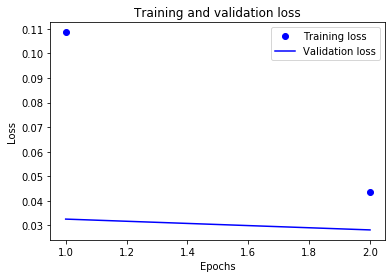

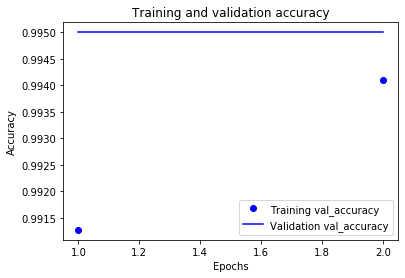

In [303]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.figure()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, acc_values, 'bo', label='Training val_accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##  Evaluate and predict

In [317]:
accuracy = model.evaluate(x_test, testLabel, verbose=1) 
#  print('Accuracy[0]: %f' % (accuracy[0] * 100))
print('Accuracy: %f' % (accuracy[1] * 100))


# ========== predict test data and write to file: 6-CisBi_Pred_Test.csv ==========================
predict = model.predict_classes(x_test)
predictClass = predict.reshape(-1)

csvTest_path = "6-2-1-BiClsMLP-NewsCisDept-balance-shuffle-rmsprop-PredCk.csv"
ckCunt = 0
#96.904027

1292/1292 [==============================] - 4s 3ms/sample - loss: 0.2131 - acc: 0.9690
Accuracy: 96.904027


In [318]:
#cftb=table(predict,testLable)
from sklearn.metrics import confusion_matrix
confusion_matrix(testLabel, predict, labels=None, sample_weight=None)
#tn, fp, fn, tp = sklearn.metrics.confusion_matrix(testLable, predict, labels=None, sample_weight=None).ravel()

#print(predict[1:10])

array([[1058,    6],
       [  34,  194]])

In [285]:
testTx=np.array(testTx)
with open(csvTest_path ,"w", newline='', encoding='utf-8-sig') as csvTest_file:
    writer = csv.writer(csvTest_file)
    #writer.writerow(["SeqNO", "Text", "Label", "Predict", "Check"])
    writer.writerow(["SeqNO", "Text", "Label", "Predict"])
    #writer.writerow(["Predict"])
    for i in range(0,len(predictClass)):
         #ck = ""
        #if testLabel[i] != predictClass[i]:
            #ck = "Check"
            #ckCunt += 1
        writer.writerow([i+1, testTx[i], testLabel[i], predictClass[i]])
        #writer.writerow([predictClass[i]])
        #,'Text':testTx[i], 'Label':testLabel[i],'Predict':predictClass[i]
     #writer.writerow(["總測試筆數=",i,"不符筆數=",ckCunt,ckCunt/i])
#print("Checked/Total = %d / %d " %(ckCunt,i))


In [300]:
1-sum(testLabel)/len(testLabel)

0.8235294117647058

##  Predict Verify data and write to file

In [286]:
# ----------- output file可置換成標的議員資料 -----------------------
vfTx_seq = token.texts_to_sequences(vfTx)
vfTx_pad = sequence.pad_sequences(vfTx_seq, maxlen=max_length, padding='post')
predNew = model.predict_classes(vfTx_pad)
predNewClass = predNew.reshape(-1)

csvPredict_path = "6-2-1-BiClsMLP-NewsCisDept-balance-shuffle-rmsprop-Predict.csv"
with open(csvPredict_path ,"w", newline='', encoding='utf-8-sig') as csvNew_file:
    writer = csv.writer(csvNew_file)
    writer.writerow(["SeqNO","FileName","Text", "Predict"])
    for i in range(0,len(predNewClass)):
        writer.writerow([i+1,vfFilename[i] ,vfTx[i], predNewClass[i]])
print("Total predict records = ", i)

Total predict records =  25111


統計分析

In [ ]:
讀黨合併
撈出非新聞的
